# Feature Selection 3 wrapper method

In [3]:
# data読み込み
import pandas as pd
# ワインのデータ
# 1つの目的変数（0列目）、ワインのクラス（３種類）
# 13個の特徴量
# 178サンプルのデータ
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values

# Split data into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [4]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


実装条件のまとめ
- dataset: ワインのデータ
- feature: 13次元
- label: 1次元(3種類のワイン)
- task: Classification（13個の特徴量からワインの種類に分類）
- model: LogisticRegression
- feature selection: wrapper method: RFE
- 評価指標: modelの精度

In [5]:
# model building
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# feature selection
# 特徴量1つだけ削除
from sklearn.feature_selection import RFE
rfe = RFE(estimator=lr, n_features_to_select=12)
X_train_rfe = rfe.fit_transform(X_train,y_train)

In [6]:
# which feature eliminated
import numpy as np
print(rfe.support_)
print(np.where(np.invert(rfe.support_)))

[ True  True  True  True False  True  True  True  True  True  True  True
  True]
(array([4]),)


In [7]:
# check performance
from sklearn.metrics import accuracy_score
lr.fit(X_train,y_train)
acc_train = accuracy_score(y_train, lr.predict(X_train))
acc = accuracy_score(y_test, lr.predict(X_test))

lr.fit(X_train_rfe,y_train)
X_test_rfe = X_test[:,rfe.support_]
acc_rfe_train = accuracy_score(y_train, lr.predict(X_train_rfe))
acc_rfe = accuracy_score(y_test, lr.predict(X_test_rfe))
print('all features | without 5th feature')
print('train:', acc_train, '|', acc_rfe_train)
print('test:', acc, '|', acc_rfe)


all features | without 5th feature
train: 0.967741935484 | 0.975806451613
test: 0.925925925926 | 0.925925925926


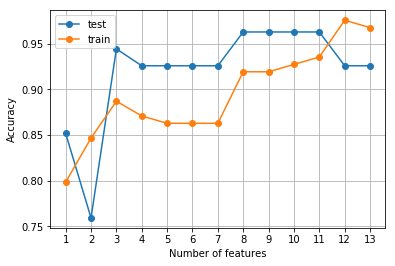

In [8]:
# 特徴量による精度の変化
acc_rfe_train=[]
acc_rfe=[]
n_features = []
for i in range(1,13+1):
    rfe = RFE(lr, i)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = X_test[:,rfe.support_]
    lr.fit(X_train_rfe,y_train)
    acc_rfe_train.append(accuracy_score(y_train, lr.predict(X_train_rfe)))
    acc_rfe.append(accuracy_score(y_test, lr.predict(X_test_rfe)))
    n_features.append(X_train_rfe.shape[1])

import matplotlib.pyplot as plt
plt.plot(n_features, acc_rfe, label='test', marker='o')
plt.plot(n_features, acc_rfe_train, label='train', marker='o')
plt.legend()
plt.grid()
plt.xticks(range(1,13+1))
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

このグラフから、今回の場合は特徴量を全て使うよりも、特徴量が8〜11個に選択したのときの方がtestの精度が高いことが分かる。次元が下がったことにより、次元の呪いが緩和され、汎化能力が上がったと考えられる。

In [9]:
# feature selection 8つ選択

rfe = RFE(estimator = lr, n_features_to_select = 8)
X_train_rfe = rfe.fit_transform(X_train, y_train)
print(np.where(rfe.support_))
X_test_rfe = X_test[:, rfe.support_]
rfe.fit(X_train_rfe, y_train)
acc_rfe_train = accuracy_score(y_train, rfe.predict(X_train_rfe))
acc_rfe = accuracy_score(y_test, rfe.predict(X_test_rfe))

print('all 13 features | only 8 features')
print('train:', acc_train, '|', acc_rfe_train)
print('test:', acc, '|', acc_rfe)


(array([ 1,  2,  3,  5,  6,  9, 10, 11]),)
all 13 features | only 8 features
train: 0.967741935484 | 0.91935483871
test: 0.925925925926 | 0.962962962963


In [10]:
import itertools
#並べる対象
s = range(13)
#並べてリスト化
c = list(itertools.combinations(s,12));
#組み合わせの数
print (len(c))

13


In [12]:
n=0
for i in range(1,14):
    n += len(list(itertools.combinations(s,i)));
print (n)

8191


# SBS Sequential Backword Selection

In [90]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
    
        dim = X_train.shape[1]                                   # Count of Dimension
        self.indices_ = tuple(range(dim))                        # Index of featuring
        self.subsets_ = [self.indices_]                          # ただlistに追加しただけ。
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):      # self.indices_からr個の組み合わせ
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)                              # 配列の最大要素のインデックスを返す
            self.indices_ = subsets[best]                         # indices_を更新することで、実質不要な特徴量を削除している。
            self.subsets_.append(self.indices_)
            dim -= 1
            print("subsets[best]",subsets[best])
            print("scores[best]",scores[best])
            print("self.indices_",self.indices_)
            print("self.subsets_",self.subsets_)
            print("self.scores_",self.scores_)
            print("_"*30)
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        print("self.score_",self.scores_)
  
        return self

    def transform(self, X):
        return X[:, self.indices_]                             # indices_のカラムだけ、全行抜く。

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)                   # indices_のカラムだけ、全行抜く。
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [91]:
# データの読み込みと train/test split
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

subsets[best] (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)
scores[best] 0.967741935484
self.indices_ (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)
self.subsets_ [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)]
self.scores_ [0.93548387096774188]
______________________________
subsets[best] (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12)
scores[best] 1.0
self.indices_ (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12)
self.subsets_ [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12)]
self.scores_ [0.93548387096774188, 0.967741935483871]
______________________________
subsets[best] (0, 1, 2, 3, 6, 7, 8, 9, 10, 12)
scores[best] 1.0
self.indices_ (0, 1, 2, 3, 6, 7, 8, 9, 10, 12)
self.subsets_ [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12), (0, 1, 2, 3, 6, 7, 8, 9, 10, 12)]
self.scores_ [0.93548387096774188, 0.967741935483871, 1.0]
______________

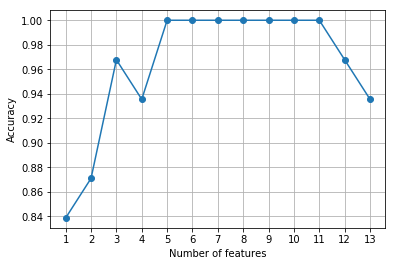

Selected top 5 features:
 Int64Index([1, 2, 4, 11, 13], dtype='int64')

Performance using all features:

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444

Performance using the top 5 features:

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


In [92]:
# Feature scaling for kNN
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.xticks(range(1,13+1))
plt.grid()
plt.show()

k5 = list(sbs.subsets_[8])
print('Selected top 5 features:\n', df_wine.columns[1:][k5])

knn.fit(X_train_std, y_train)
print('\nPerformance using all features:\n')
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

knn.fit(X_train_std[:, k5], y_train)
print('\nPerformance using the top 5 features:\n')
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

In [86]:
sbs.k_score_

0.83870967741935487